# Analyzing detailed narrative disclosure (that comes with earnings report) which provides information helpful for interpreting performance using a few different machine learning approaches.

**1. Apply topic modeling for understading type of language used 2. Apply Lasso to evaluate topics that best predict stock returns 3. Train classifier to understand whether earnings announcements can be used to predict large positive returns**

In [1]:
import pandas as pd
import re
import tmtoolkit
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation as LDA
from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
import numpy as np


In [16]:
# Insert code to load the dataset into a dataframe called "df"

df = pd.read_csv("./ExpTask2Data.csv.gz")
df


,File_Name,ea_text,datacqtr,announce_date,BHAR0_2
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501
...,...,...,...,...,...
12495,883902-0000883902-20-000016.txt,EX-99.1 2 a2019q4exh991. htm EX-99.1 Docum...,2019Q4,3/3/2020,5.110050
12496,917470-0001157523-08-006146.txt,EX-99.1 2 a5744289-ex991. htm EXHIBIT 99.1 ...,2008Q2,7/31/2008,-17.319616
12497,1058090-0001193125-07-166748.txt,EX-99.1 2 dex991. htm PRESS RELEASE Press Rel...,2007Q2,7/31/2007,26.078641
12498,1049502-0001299933-09-002997.txt,EX-99.1 2 exhibit1. htm EX-99.1 EX-99.1 (...,2009Q2,7/22/2009,8.731096


**Pre-process**

In [3]:

def clean_sentences(txt):
    #regular expression to "..." to clean out financial numbers:
    clean_txt = re.sub(r"\b\d+\b"," financial_number ",txt) 
    good_sents = []
    
    #tokenize sentences = generate list of sentences 
    sentences = sent_tokenize(clean_txt)
    
    for sent in sentences:
        good_tokens = []
        tokens = word_tokenize(sent) #tokenize words in the sentence 
        
        for token in tokens:               
            # apply logic above, building list of "good tokens"=filter out non-alpha or non-"financial_number"
            if token.isalpha() or token =="financial_number":
                good_tokens.append(token)
                
                
        # logic to check if there are sufficient tokens to keep the sentence (5 or more tokens, no more than 50% financial numbers):
        if len(good_tokens) >=5 and (good_tokens.count("financial_number")/len(good_tokens)) <=0.5:
            good_sents.append(sent)
                
    
    return " ".join(good_sents)        

**Apply function to the text ("ea_text") column..takes about 15-20 mins to run.**

In [4]:
df['clean_sent'] =df['ea_text'].apply(clean_sentences)
df.head(5)

,File_Name,ea_text,datacqtr,announce_date,BHAR0_2,clean_sent
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975,financial_number NEWS RELEASE C20...
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589,htm PRESS RELEASE exv99w1 EXHIBIT financ...
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353,financial_number O S H K O S H C O R P O ...
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058,financial_number Cabot Corp Reports Se...
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501,"htm PRESS RELEASE THE DIXIE GROUP, INC EXH..."


**Saving dataframe to avoid re-running the above code.**

In [5]:
# To save:
df.to_csv("./task2_data_clean.csv.gz",index=False)

In [2]:
# To load:
df = pd.read_csv("./task2_data_clean.csv.gz")

In [3]:
df

,File_Name,ea_text,datacqtr,announce_date,BHAR0_2,clean_sent
0,714603-0001104659-11-059721.txt,EX-99.1 3 a11-28994_1ex99d1. htm EX-99.1 Exh...,2011Q3,10/28/2011,-4.513975,financial_number NEWS RELEASE C20...
1,772897-0000950134-06-020331.txt,EX-99.1 2 c09674exv99w1. htm PRESS RELEASE ex...,2006Q3,11/2/2006,-2.001589,htm PRESS RELEASE exv99w1 EXHIBIT financ...
2,775158-0001564590-20-048540.txt,EX-99.1 2 osk-ex991_6. htm EX-99.1 osk-ex99...,2020Q3,10/29/2020,-2.112353,financial_number O S H K O S H C O R P O ...
3,16040-0001157523-20-000728.txt,EX-99.1 2 a52217903ex99_1. htm EXHIBIT 99.1 ...,2020Q1,5/11/2020,-9.170058,financial_number Cabot Corp Reports Se...
4,29332-0000029332-07-000098.txt,EX-99.1 2 ex991pressrel73107. htm PRESS RELEAS...,2007Q2,7/31/2007,8.671501,"htm PRESS RELEASE THE DIXIE GROUP, INC EXH..."
...,...,...,...,...,...,...
12495,883902-0000883902-20-000016.txt,EX-99.1 2 a2019q4exh991. htm EX-99.1 Docum...,2019Q4,3/3/2020,5.110050,financial_number DocumentNEWS RELEASECorn...
12496,917470-0001157523-08-006146.txt,EX-99.1 2 a5744289-ex991. htm EXHIBIT 99.1 ...,2008Q2,7/31/2008,-17.319616,financial_number Olympic Steel Report...
12497,1058090-0001193125-07-166748.txt,EX-99.1 2 dex991. htm PRESS RELEASE Press Rel...,2007Q2,7/31/2007,26.078641,htm PRESS RELEASE Press Release Exhibit fina...
12498,1049502-0001299933-09-002997.txt,EX-99.1 2 exhibit1. htm EX-99.1 EX-99.1 (...,2009Q2,7/22/2009,8.731096,financial_number (MKS LOGO) EXHIBIT fina...


**Generating document term matrix using CountVectorizer (since going to fit LDA model)**

In [4]:

stops = stopwords.words('english') #set(stopwords.words('english'))

vec = CountVectorizer(token_pattern = r'\b[a-zA-Z_]{3,}[a-zA-Z]*\b',
                      stop_words = stops,   #list(stops),
                      ngram_range = (1,2),
                      max_features = 1000,
                     max_df = 0.5) 
dtm = vec.fit_transform(df['clean_sent'])
dtm

<12500x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 3486369 stored elements in Compressed Sparse Row format>

**Fitting LDA model**

In [5]:

# sample of 5000 for training; use random_state=123
sample = pd.DataFrame(dtm.todense()).sample(5000,random_state=123)

# Set up "vocab", a list of feature names
vocab = np.array(vec.get_feature_names_out())


# Set up empty list to collect diagnostics
records = []
for top in range(40, 151, 10): #trying between 40 and 150 topics
    print(f"Fitting {top} topics")
    record = {'topics':top}
    # Fill in missing parameters
    lda = LDA(n_components = top,
              topic_word_prior = 0.15,
              doc_topic_prior = 25/top,
              n_jobs = -1,
              random_state=123)

    lda.fit(sample) # Add code to fit the best model & generate topic scores 
    top_word = lda.components_
    
    ## Add code to compute umass, add mean umass to "record", and collect record in list
    umass = metric_coherence_gensim(measure="u_mass",
                                   top_n=5,
                                   topic_word_distrib = top_word,
                                   dtm = sample.values,
                                   vocab = vocab,
                                   texts = None)
    record['mean_umass'] = np.mean(umass)
    records.append(record)

Fitting 40 topics
Fitting 50 topics
Fitting 60 topics
Fitting 70 topics
Fitting 80 topics
Fitting 90 topics
Fitting 100 topics
Fitting 110 topics
Fitting 120 topics
Fitting 130 topics
Fitting 140 topics
Fitting 150 topics


**Using coherence score, u_mass, to evaluate topic quality and choosing optimum number of topics.**

In [6]:
diagnostics = pd.DataFrame(records)
diagnostics

,topics,mean_umass
0,40,-0.864725
1,50,-0.842592
2,60,-0.889662
3,70,-0.848689
4,80,-0.852778
5,90,-0.876745
6,100,-0.851519
7,110,-0.861324
8,120,-0.863381
9,130,-0.876151


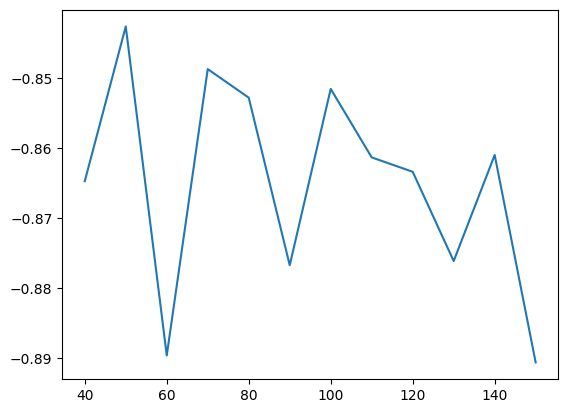

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(diagnostics['topics'],diagnostics['mean_umass'])

**The mean_umass seems to be the lowest for 50 topics, thus selecting optimum number of topics around 50.**

**Fitting a final LDA model using 50 topics**

In [8]:

best_model_record = max(records, key=lambda x: x['mean_umass'])
optimal_topics = best_model_record['topics']

# Set up final lda model:
final_lda = LDA(
    n_components=50, #50 topics 
    topic_word_prior=0.15,
    doc_topic_prior=25 / 50,
    n_jobs=-1,
    random_state=123
)


# Fit final model and transform the DTM
topics = final_lda.fit_transform(dtm)

In [9]:
topics # view topics matrix

array([[0.04072831, 0.00036659, 0.00151792, ..., 0.00060348, 0.00039895,
        0.01823853],
       [0.00139061, 0.08262306, 0.00102112, ..., 0.00403085, 0.00106431,
        0.00158619],
       [0.0016996 , 0.00095495, 0.00090434, ..., 0.00066517, 0.0006053 ,
        0.01323188],
       ...,
       [0.00191241, 0.00213517, 0.0012099 , ..., 0.00191902, 0.00143915,
        0.0012808 ],
       [0.00126382, 0.00123792, 0.00191831, ..., 0.00182402, 0.00114119,
        0.00129105],
       [0.0085591 , 0.15459034, 0.00100014, ..., 0.00118851, 0.00151215,
        0.00116891]])

In [10]:
topics.shape

(12500, 50)

**Inspecting top 5 words associated with each topic and a randomly chosen word from the vocabulary, separately identified as an intruder.**

In [11]:
import random
topn = 5

vocab = np.array(vec.get_feature_names_out())
top_word = final_lda.components_

def get_topic_words(topic, top_word, vocab, topn):
    top_words_indices = top_word[topic, :].argsort()[-topn:][::-1]
    top_words = vocab[top_words_indices]
    return top_words

# perform the intrusion task
num_topics=len(top_word)

for top in range(num_topics):
    words = get_topic_words(top,top_word,vocab,topn)
    intruder = random.choice([w for w in vocab if w not in words])
    print(f"Topic {top} words: {' | '.join(words)}\t Intruder: {intruder}")

Topic 0 words: tax rate | effective | pension | effective tax | segment	 Intruder: project
Topic 1 words: financial_number deferred | payable financial_number | total current | financial_number shares | stockholders equity	 Intruder: used operating
Topic 2 words: adjusted operating | intangible | financial_number adjusted | fair | fair value	 Intruder: partners
Topic 3 words: eps | diluted earnings | diluted eps | acquisition related | gaap operating	 Intruder: fees
Topic 4 words: construction | segment | prices | industries | materials	 Intruder: period period
Topic 5 words: june | june financial_number | restricted | restricted cash | cash used	 Intruder: financial_number revenues
Topic 6 words: network | wireless | access | communications | technology	 Intruder: effective tax
Topic 7 words: pre | pre tax | charge | tax financial_number | charge financial_number	 Intruder: order
Topic 8 words: june | june financial_number | ended june | six | six months	 Intruder: income adjusted
Top

# Fitting Lasso to evaluate which topics most strongly predict stock returns: "BHAR0_2" (or buy-and-hold abnormal returns from days 0 to 2). Note that this column is in percentage points (i.e., -4.5 indicates a return of -4.5%).*

In [12]:
from sklearn.model_selection import train_test_split

Xtopic_train, Xtopic_test, Ytopic_train, Ytopic_test = train_test_split(topics, df['BHAR0_2'],test_size=0.2,random_state=123)

In [13]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
import numpy as np

np.random.seed(123)

#the optimum out-of-sample value for alpha
param_grid = {'random_state': [123],
    'alpha': np.random.uniform(0.00001, 0.02, 100) #100 random values for alpha between 0.00001 and 0.02.
}

lasso = Lasso()

rus = RandomizedSearchCV(
    lasso,
    param_grid,
    n_iter=50, #run 50 times
    scoring='neg_root_mean_squared_error',
    cv=5,   #use 5-fold cross-validation
    n_jobs=-1,
)

rus.fit(Xtopic_train, Ytopic_train)


RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': array([0.01393242, 0.00572993, 0.00454476, 0.01103078, 0.01439218,
       0.0084679 , 0.01961548, 0.01369975, 0.00962383, 0.00784843,
       0.00687013, 0.0145837 , 0.00877706, 0.00120296, 0.0079669 ,
       0.01476253, 0.00365801, 0.00351728, 0.01063571, 0.01064123,
       0.01269168, 0.01699014, 0.01449186, 0....
       0.00192329, 0.01770768, 0.01254871, 0.01447109, 0.00033242,
       0.01189269, 0.01114014, 0.0031876 , 0.00306988, 0.01391364,
       0.00638214, 0.01384249, 0.01109212, 0.00778512, 0.0185034 ,
       0.01683498, 0.00715438, 0.00088139, 0.00610231, 0.00796973,
       0.01410213, 0.01990722, 0.00712474, 0.01525333, 0.01186761,
       0.01383712, 0.00303104, 0.00798354, 0.00482471, 0.00687569]),
                                        'random_state': [123]},
                   scoring='neg_root_mean_squared_error')

**Plot neg_root_mean_squared_error vs. alpha**

In [14]:
rus.cv_results_['param_alpha'][:10:]

masked_array(data=[0.010641233466066352, 0.011722871685718636,
                   0.018883758763895555, 0.0068756857208260155,
                   0.012691675161440909, 0.001851177749502053,
                   0.008777059171145692, 0.017510382267485546,
                   0.014491861943964098, 0.01445164321757873],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object)

In [15]:
rus.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_random_state', 'param_alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

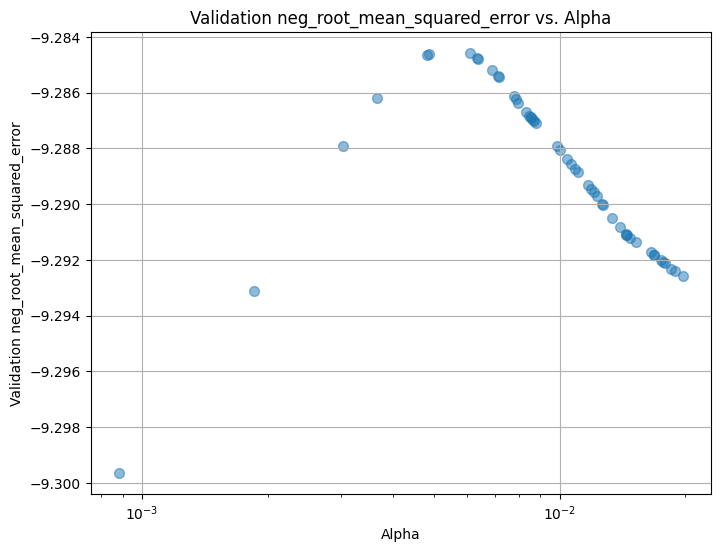

In [16]:
import matplotlib.pyplot as plt

alphas = rus.cv_results_['param_alpha']
neg_rmse = rus.cv_results_['mean_test_score']

# Creating a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(alphas, neg_rmse, s=50, alpha=0.5)
plt.title('Validation neg_root_mean_squared_error vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('Validation neg_root_mean_squared_error')
plt.xscale('log') 
plt.grid(True)
plt.show()

In [17]:
optimum_alpha=rus.best_params_['alpha']

print("Optimum value for alpha:", optimum_alpha)


Optimum value for alpha: 0.00608937457265341


**Lasso results**

In [18]:
lasso = Lasso(alpha=optimum_alpha,  # rus.cv_results_['param_alpha']
              random_state=123)
lasso.fit(Xtopic_train, Ytopic_train)

nonzero_coef=len([c for c in lasso.coef_ if c!=0])
   
print(f"number of coefficients not equal to zero is {nonzero_coef}")


number of coefficients not equal to zero is 9


**The most positive and most negative topics.**

In [19]:
most_pos = np.argmax(lasso.coef_)
most_neg = np.argmin(lasso.coef_)

print(f"The most positive coefficient corresponds to topic {most_pos} and has a value {lasso.coef_[most_pos]}.")
print(f"The most negative coefficient corresponds to topic {most_neg} and has a value {lasso.coef_[most_neg]}.")

The most positive coefficient corresponds to topic 3 and has a value 2.8664809610332798.
The most negative coefficient corresponds to topic 44 and has a value -5.123652454979049.


**Top 5 words corresponding to the most positive and negative topics.**

In [20]:
topn=5
vocab = np.array(vec.get_feature_names_out())

In [21]:
# Positive words:
words = get_topic_words(most_pos, top_word, vocab, topn=5)
print(f"Topic {most_pos} words: {'|'.join(words)}")

# Negative words:
words = get_topic_words(most_neg, top_word, vocab, topn=5)
print(f"Topic {most_neg} words: {'|'.join(words)}")

Topic 3 words: eps|diluted earnings|diluted eps|acquisition related|gaap operating
Topic 44 words: income loss|net loss|loss per|basic diluted|gaap net


**The words do seem to be intuitive, especially the words for positive topic. Most of the positive words do have strong association with stock returns. The last two negative words 'basic diluted' and 'gaap net' do not seem very intutive.**

# Predict Large Positive Returns Using a Classifier

In [24]:
YLR = (df['BHAR0_2']>5).astype(int) #reducing dataset 
train_Xdtm, test_Xdtm, train_Xtopic, test_Xtopic, train_YLR, test_YLR = train_test_split(np.asarray(dtm.todense()),topics,YLR,train_size=0.80,random_state=123)

In [23]:
# Get unique classes and their counts
unique_classes, counts = np.unique(train_YLR, return_counts=True)

# Display counts for each class
for class_label, count in zip(unique_classes, counts):
    print(f"Class {class_label}: Count - {count}")

Class 0: Count - 7584
Class 1: Count - 2416


**Training Random Forest**

In [25]:
# Train and evaluate 1st model

from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, classification_report

n_estimators = [50,100,250]
max_samples = [1,0.75,0.25] #%

for n in n_estimators:
    for m in max_samples:
        rf = RFC(n_estimators=n, max_samples=m, n_jobs = -1, random_state=123, class_weight='balanced')
        print(f"Running Random Forest model with {n} estimators and a max of {round(m*100,2)}% observations per tree.")
        rf.fit(train_Xtopic,train_YLR)
        print(f"Classification Report for this model using validation data:\n\n")
        print(classification_report(test_YLR,rf.predict(test_Xtopic)))
        print(f"Classification Report for this model using training data:\n\n")
        print(classification_report(train_YLR,rf.predict(train_Xtopic)))
        print("------------------------------------------------------------")

Running Random Forest model with 50 estimators and a max of 100% observations per tree.
Classification Report for this model using validation data:


              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1904
           1       0.00      0.00      0.00       596

    accuracy                           0.76      2500
   macro avg       0.38      0.50      0.43      2500
weighted avg       0.58      0.76      0.66      2500

Classification Report for this model using training data:


              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7584
           1       0.00      0.00      0.00      2416

    accuracy                           0.76     10000
   macro avg       0.38      0.50      0.43     10000
weighted avg       0.58      0.76      0.65     10000

------------------------------------------------------------
Running Random Forest model with 50 estimators and a max of 75.0% observati

C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\

Classification Report for this model using validation data:


              precision    recall  f1-score   support

           0       0.76      1.00      0.87      1904
           1       0.75      0.01      0.02       596

    accuracy                           0.76      2500
   macro avg       0.76      0.50      0.44      2500
weighted avg       0.76      0.76      0.66      2500

Classification Report for this model using training data:


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7584
           1       1.00      0.97      0.98      2416

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.99     10000
weighted avg       0.99      0.99      0.99     10000

------------------------------------------------------------
Running Random Forest model with 50 estimators and a max of 25.0% observations per tree.
Classification Report for this model using validation data:


            

C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\

Classification Report for this model using validation data:


              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1904
           1       0.67      0.01      0.01       596

    accuracy                           0.76      2500
   macro avg       0.71      0.50      0.44      2500
weighted avg       0.74      0.76      0.66      2500

Classification Report for this model using training data:


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7584
           1       1.00      0.99      1.00      2416

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

------------------------------------------------------------
Running Random Forest model with 100 estimators and a max of 25.0% observations per tree.
Classification Report for this model using validation data:


           

C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for this model using validation data:


              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1904
           1       0.00      0.00      0.00       596

    accuracy                           0.76      2500
   macro avg       0.38      0.50      0.43      2500
weighted avg       0.58      0.76      0.66      2500

Classification Report for this model using training data:


              precision    recall  f1-score   support

           0       0.76      1.00      0.86      7584
           1       0.00      0.00      0.00      2416

    accuracy                           0.76     10000
   macro avg       0.38      0.50      0.43     10000
weighted avg       0.58      0.76      0.65     10000

------------------------------------------------------------
Running Random Forest model with 250 estimators and a max of 75.0% observations per tree.


C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\

Classification Report for this model using validation data:


              precision    recall  f1-score   support

           0       0.76      1.00      0.87      1904
           1       0.71      0.01      0.02       596

    accuracy                           0.76      2500
   macro avg       0.74      0.50      0.44      2500
weighted avg       0.75      0.76      0.66      2500

Classification Report for this model using training data:


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7584
           1       1.00      1.00      1.00      2416

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

------------------------------------------------------------
Running Random Forest model with 250 estimators and a max of 25.0% observations per tree.
Classification Report for this model using validation data:


           

C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\stuti\.conda\envs\unstruct\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Training Light Gradient Boosting.**

In [26]:
# Train and evaluate 2nd model
from lightgbm import LGBMClassifier as LGBM

lgbm = LGBM(reg_alpha=0.01,random_state=123,n_jobs=-1)
lgbm.fit(train_Xtopic,train_YLR)

print(f"Classification Report for this model using validation data:\n\n")
print(classification_report(test_YLR,lgbm.predict(test_Xtopic)))
print(f"Classification Report for this model using training data:\n\n")
print(classification_report(train_YLR,lgbm.predict(train_Xtopic)))
print("------------------------------------------------------------")

[LightGBM] [Info] Number of positive: 2416, number of negative: 7584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241600 -> initscore=-1.143927
[LightGBM] [Info] Start training from score -1.143927
Classification Report for this model using validation data:


              precision    recall  f1-score   support

           0       0.76      0.99      0.86      1904
           1       0.45      0.03      0.05       596

    accuracy                           0.76      2500
   macro avg       0.61      0.51      0.46      2500
weighted avg       0.69      0.76      0.67      2500

Classification Report for this model using training data:


              precision    recall  f1-score   support

   

**Evaluating Classifiers: The percent of accuracy for both models, Random Forest and Light GBM, are high using both the training dataset and validation dataset. However the models are all biased based on the precision, recall and f1-score. The models are able to predict class 1 well but they are doing a very poor job of predicting the minority class 0. It makes sense as about 75% of data belonged to class 1. We could try to tune some hyper parameters below to see if that improves the biaseness.**

**Model Tuning**


In [29]:

np.random.seed(123)
maj_weight = np.random.uniform(0,0.5,100) # 100 random numbers between 0 and 0.5
class_weights = [{0: 1-k, 1:k} for k in maj_weight] #0 will be whatever value from maj_weight subtracted from 1
class_weights.append('balanced') # adds "balanced" as an option
class_weights.append(None) # adds no weighting as an option..default for most procedures
class_weights[-10:]

rf_params = {'n_estimators':[10,25,50,100,200],
             'criterion':['gini','entropy','log_loss'],
             'max_depth':[None,10, 20, 50, 100],
             'min_samples_split':[2,5,10], # required to split
             'max_features':[None,'sqrt','log2'],
             'max_samples':[None,0.10,0.50,0.75],
             'class_weight':class_weights,
             'random_state':[123]
            }

lgbm_params = {'boosting_type':['gbdt', 'dart', 'goss'],
               'num_leaves':[10,20,30,40,50],
               'max_depth':[-1, 10, 20, 50, 100],
               'learning_rate':[0.01,0.1,0.2,0.5], # note this is a very important parameter, as it controls how much "feedback" the model has. You can also define a function to make it adaptive
               'n_estimators':[25,50,75,100,200],
               'class_weight':class_weights,
               'random_state':[123]
              }

In [30]:
from sklearn.model_selection import RandomizedSearchCV
final_mods = []
for mod,params in zip([RFC(),LGBM()],[rf_params, lgbm_params]): # zip creates a list of tuples we can use to iterate
    rand_search = RandomizedSearchCV(mod,params, # positional arguments, model and parameter grid
                                     n_iter=25,
                                     scoring='f1_macro', # see options here: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                                     cv=5,
                                     random_state=123,
                                     n_jobs=-1)
    
    rand_search.fit(train_Xtopic,train_YLR)
    print(f"Classification Report with hold-out sample for best fit of this model:...\n")
    print(type(mod))
    print(classification_report(test_YLR,rand_search.predict(test_Xtopic)))
    print("------------------------------------------------------")
    final_mods.append(rand_search)

Classification Report with hold-out sample for best fit of this model:...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1904
           1       0.20      0.03      0.05       596

    accuracy                           0.74      2500
   macro avg       0.48      0.50      0.45      2500
weighted avg       0.63      0.74      0.66      2500

------------------------------------------------------
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 2416, number of negat

**Final classification report**

In [31]:
print(final_mods[1].best_estimator_)

LGBMClassifier(boosting_type='goss',
               class_weight={0: 0.6187260931072831, 1: 0.3812739068927169},
               learning_rate=0.2, max_depth=20, num_leaves=50,
               random_state=123)


In [32]:
from sklearn.metrics import classification_report
# Update "mod" to be your final model and "test_Xdtm" to be whatever X you used)

lgbm_best = LGBM(boosting_type='goss',
               class_weight={0: 0.6187260931072831, 1: 0.3812739068927169},
               learning_rate=0.2, max_depth=20, n_estimators=200, num_leaves=50,
               random_state=123)
lgbm_best.fit(train_Xtopic,train_YLR)

print(classification_report(test_YLR,lgbm_best.predict(test_Xtopic)))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 2416, number of negative: 7584
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 50
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.164095 -> initscore=-1.628072
[LightGBM] [Info] Start training from score -1.628072
[LightGBM] [Warning] Found boosting=goss. For backwa

**Both models after tuning the hyper parameters including adjusting class_weights decreased their overall accuracy but the recall values improved. The improvement was more significant for Light GBM for class 1. This model can still be improved more by applying other methods such as dimension reduction or resampling.**